In [ ]:
# ============================================================
# 📊 LLM Load Test CSV Analysis
# ============================================================
# This notebook visualizes:
#   - Requests/sec and Failures/sec
#   - 10s moving average of Input Tokens
#   - 10s moving average of Output Tokens
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# csv_path = "llm_load_results_deepinfra.csv"
# csv_path = "llm_load_results_phoenix.csv"
csv_path = "llm_load_results_selfhost.csv"
print(f"✅ Loaded: {csv_path}")

# --- Load data ---
df = pd.read_csv(csv_path, parse_dates=["timestamp_start", "timestamp_end"])
print(f"Rows: {len(df)}")
df.head()

✅ Loaded: llm_load_results_deepinfra.csv
Rows: 4282


,timestamp_start,timestamp_end,status_code,input_tokens,output_tokens,time_to_first_token,concurrency_at_start,source_filename,truncated_output
0,2025-10-20 15:12:44.824406,2025-10-20 15:13:03.403400,200,1402,907,18.579,2,simple_request.json,## 테이블 분석 및 JSON/Narrative 텍스트 생성 지침 (한국어) **...
1,2025-10-20 15:12:44.809138,2025-10-20 15:13:03.575382,200,2730,831,18.766,1,api-req3.json,**1. 테이블 구조 분석:** * **테이블 제목:** “(표 1) OIS에...
2,2025-10-20 15:12:44.770374,2025-10-20 15:13:07.930209,200,2730,1008,23.160,0,api-req2.json,**1. 테이블 구조 분석:** * **테이블 제목:** 표2) 주요국 소비자...
3,2025-10-20 15:12:50.837433,2025-10-20 15:13:09.572336,200,2730,822,18.735,5,api-req2.json,**1. 테이블 구조 분석:** * **테이블 제목:** «표2» 주요국 소비...
4,2025-10-20 15:12:48.814032,2025-10-20 15:13:13.562441,200,1191,1219,24.748,4,5.json,"{""figure_title"":""Characteristics of InternVL 1..."


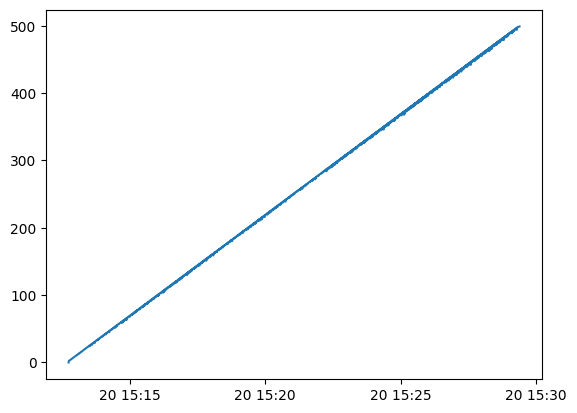

In [197]:
plt.plot(df.timestamp_start, df.concurrency_at_start)

In [190]:
# Ensure timestamp sort order
df = df.sort_values("timestamp_start")

# Round timestamps to 1-second buckets
df["second"] = df["timestamp_start"].dt.floor("S")

# Compute derived columns
df["duration_s"] = (df["timestamp_end"] - df["timestamp_start"]).dt.total_seconds()
df["success"] = df["status_code"].apply(lambda x: 200 <= x < 300)
df["failed"] = ~df["success"]


/var/folders/q4/6v5gb2jx49l8k5d3rwfd_x3c0000gn/T/ipykernel_2716/4269376089.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["second"] = df["timestamp_start"].dt.floor("S")


/Users/danielwarfield/Documents/GitHub/DeepInfraThroughputTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


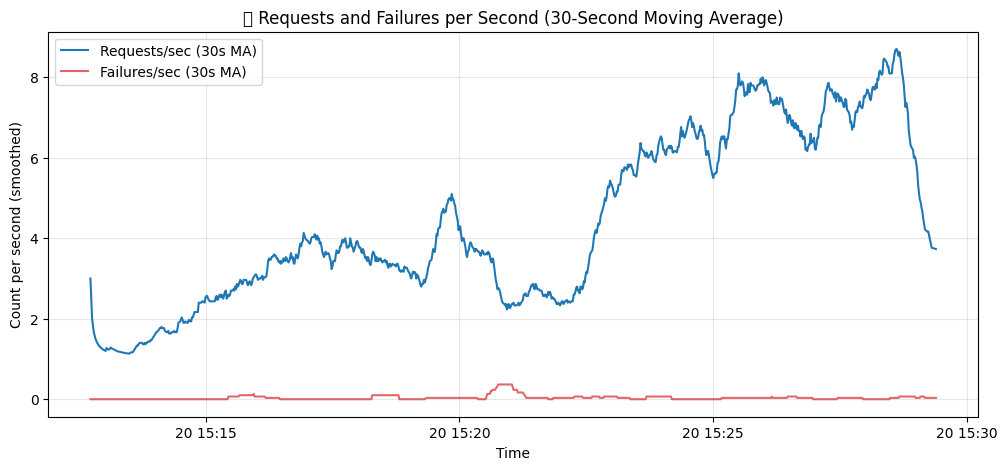

In [191]:
# Group by second
rps = df.groupby("second").agg(
    requests_per_s=("status_code", "count"),
    failures_per_s=("failed", "sum"),
).reset_index()

# 30-second moving average
rps["requests_per_s_ma30"] = rps["requests_per_s"].rolling(window=30, min_periods=1).mean()
rps["failures_per_s_ma30"] = rps["failures_per_s"].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(rps["second"], rps["requests_per_s_ma30"], label="Requests/sec (30s MA)", color="tab:blue")
plt.plot(rps["second"], rps["failures_per_s_ma30"], label="Failures/sec (30s MA)", color="tab:red", alpha=0.7)
plt.title("📊 Requests and Failures per Second (30-Second Moving Average)")
plt.xlabel("Time")
plt.ylabel("Count per second (smoothed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/Users/danielwarfield/Documents/GitHub/DeepInfraThroughputTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


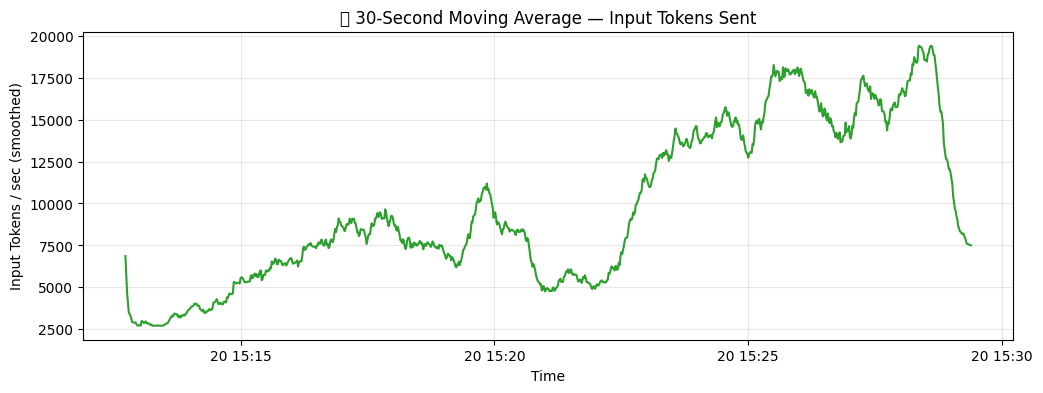

In [192]:
# Compute per-second average input tokens
tokens_in = df.groupby("second")["input_tokens"].sum().reset_index(name="input_tokens_total")

# 30-second moving average
tokens_in["input_tokens_30s_avg"] = tokens_in["input_tokens_total"].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(tokens_in["second"], tokens_in["input_tokens_30s_avg"], color="tab:green")
plt.title("🟩 30-Second Moving Average — Input Tokens Sent")
plt.xlabel("Time")
plt.ylabel("Input Tokens / sec (smoothed)")
plt.grid(True, alpha=0.3)
plt.show()


/Users/danielwarfield/Documents/GitHub/DeepInfraThroughputTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


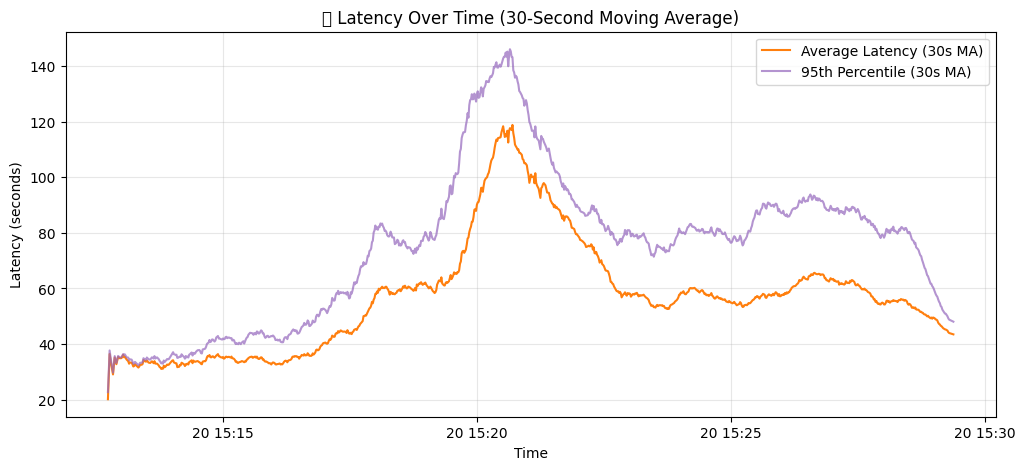

In [193]:
# ------------------------------------------------------------
# ⏱️ Latency graph: shows how request durations evolve over time
# ------------------------------------------------------------

# Compute latency (in seconds)
df["latency_s"] = (df["timestamp_end"] - df["timestamp_start"]).dt.total_seconds()

# Group per second and compute average latency
latency = df.groupby("second").agg(
    avg_latency=("latency_s", "mean"),
    p95_latency=("latency_s", lambda x: x.quantile(0.95)),
).reset_index()

# 30-second moving averages for smoothing
latency["avg_latency_ma30"] = latency["avg_latency"].rolling(window=30, min_periods=1).mean()
latency["p95_latency_ma30"] = latency["p95_latency"].rolling(window=30, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(latency["second"], latency["avg_latency_ma30"], label="Average Latency (30s MA)", color="tab:orange")
plt.plot(latency["second"], latency["p95_latency_ma30"], label="95th Percentile (30s MA)", color="tab:purple", alpha=0.7)
plt.title("⏱️ Latency Over Time (30-Second Moving Average)")
plt.xlabel("Time")
plt.ylabel("Latency (seconds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/Users/danielwarfield/Documents/GitHub/DeepInfraThroughputTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


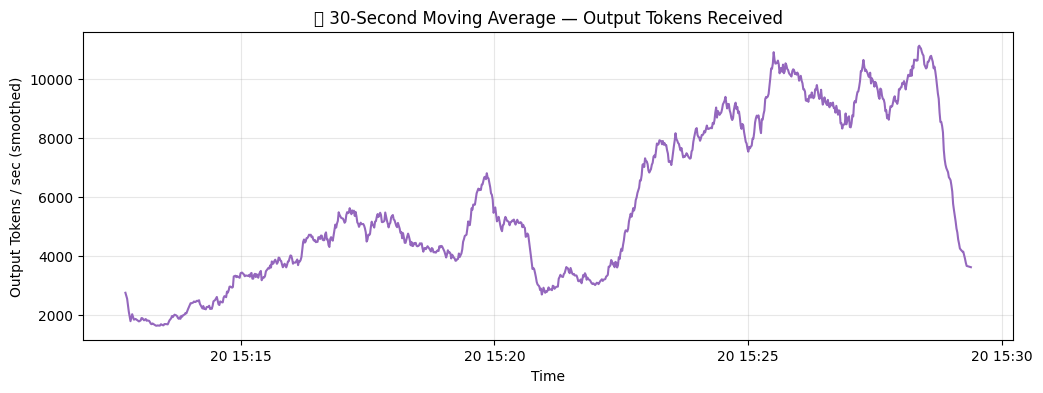

In [194]:
tokens_out = df.groupby("second")["output_tokens"].sum().reset_index(name="output_tokens_total")

# 30-second moving average
tokens_out["output_tokens_30s_avg"] = tokens_out["output_tokens_total"].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(tokens_out["second"], tokens_out["output_tokens_30s_avg"], color="tab:purple")
plt.title("🟦 30-Second Moving Average — Output Tokens Received")
plt.xlabel("Time")
plt.ylabel("Output Tokens / sec (smoothed)")
plt.grid(True, alpha=0.3)
plt.show()

In [195]:
summary = {
    "total_requests": len(df),
    "success_rate": df["success"].mean(),
    "avg_duration_sec": df["duration_s"].mean(),
    "avg_input_tokens": df["input_tokens"].mean(),
    "avg_output_tokens": df["output_tokens"].mean(),
}
pd.DataFrame([summary])


,total_requests,success_rate,avg_duration_sec,avg_input_tokens,avg_output_tokens
0,4282,0.991826,58.390613,2221.077767,1304.146193


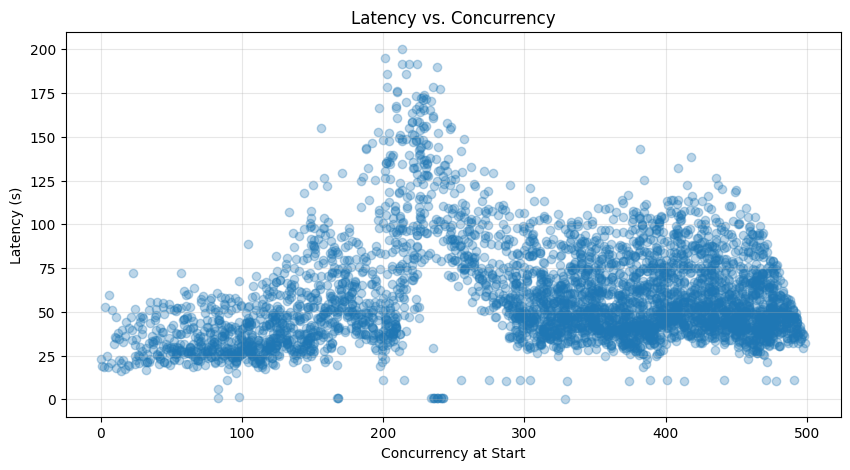

In [196]:
plt.figure(figsize=(10, 5))
plt.scatter(df["concurrency_at_start"], df["latency_s"], alpha=0.3)
plt.title("Latency vs. Concurrency")
plt.xlabel("Concurrency at Start")
plt.ylabel("Latency (s)")
plt.grid(True, alpha=0.3)
plt.show()
